In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import polars as pl
import datetime
import altair as alt

In [2]:
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [3]:
# Perform depth-first search (DFS) to find all conjugated bond paths
def dfs(graph, bond_idx, visited):
    visited.add(bond_idx)
    max_chain = []
    for neighbor, is_connected in enumerate(graph[bond_idx]):
        if is_connected and neighbor not in visited:
            chain = dfs(graph, neighbor, visited)
            if len(chain) > len(max_chain):
                max_chain = chain
    visited.remove(bond_idx)
    return [bond_idx] + max_chain

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Geometry import Point2D
from IPython.display import SVG  # For displaying SVG directly in Jupyter notebooks

# Function to label bond indices on a molecule
def label_bonds(mol):
    # Generate 2D coordinates for visualization
    Chem.rdDepictor.Compute2DCoords(mol)

    # Define image size and initialize an SVG drawer
    drawer = Draw.MolDraw2DSVG(300, 300)

    # Draw the molecule first
    drawer.DrawMolecule(mol)

    # Add bond numbers in red
    for bond in mol.GetBonds():
        idx = bond.GetIdx()
        begin_atom_pos = mol.GetConformer().GetAtomPosition(bond.GetBeginAtomIdx())
        end_atom_pos = mol.GetConformer().GetAtomPosition(bond.GetEndAtomIdx())

        # Calculate midpoint of bond
        mid_x = (begin_atom_pos.x + end_atom_pos.x) / 2
        mid_y = (begin_atom_pos.y + end_atom_pos.y) / 2

        # Offset the y coordinate to move the label just above the bond
        offset_y = 1.1  # Adjust this value to control how far above the bond the label is
        mid_point = Point2D(mid_x, mid_y + offset_y)

        # Set label color to red and add bond index at the offset midpoint
        drawer.SetColour((1.0, 0.0, 0.0))  # Red color (R, G, B)
        drawer.DrawString(str(idx), mid_point)

    # Finish drawing
    drawer.FinishDrawing()

    # Get the SVG text
    svg = drawer.GetDrawingText()

    # Display the SVG image (if you're in a Jupyter notebook)
    display(SVG(svg))

    # Save the SVG to a file (optional)
    with open("molecule_with_bond_numbers.svg", "w") as f:
        f.write(svg)

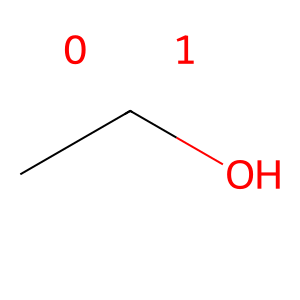

In [5]:
label_bonds(Chem.MolFromSmiles("CCO"))

In [6]:
from rdkit import Chem
import numpy as np

def get_longest_conjugated_bond_chain(mol):
    num_bonds = mol.GetNumBonds()
    
    # Create a list to store conjugated bond indices
    conjugated_bonds = [bond.GetIdx() for bond in mol.GetBonds() if bond.GetIsConjugated()]
    num_conjugated_bonds = len(conjugated_bonds)
    # print(f"  # bonds: {num_bonds} total, {num_conjugated_bonds} conjugated.")
    
    if not conjugated_bonds:
        return []  # No conjugated bonds found, return empty list
    
    # Build a subgraph of only conjugated bonds
    bond_matrix = np.zeros((len(conjugated_bonds), len(conjugated_bonds)), dtype=int)
    
    # Populate the bond adjacency matrix for conjugated bonds
    for i, bond_i in enumerate(conjugated_bonds):
        bond_i_obj = mol.GetBondWithIdx(bond_i)
        for j, bond_j in enumerate(conjugated_bonds):
            if i != j:
                bond_j_obj = mol.GetBondWithIdx(bond_j)
                # Check if two conjugated bonds share an atom
                if len(set([bond_i_obj.GetBeginAtomIdx(), bond_i_obj.GetEndAtomIdx()]) & 
                       set([bond_j_obj.GetBeginAtomIdx(), bond_j_obj.GetEndAtomIdx()])) > 0:
                    bond_matrix[i, j] = 1
                    bond_matrix[j, i] = 1

    # Find connected components in the conjugated bond subgraph
    def find_connected_component(graph, start_bond, visited):
        stack = [start_bond]
        connected_component = []
        
        while stack:
            bond_idx = stack.pop()
            if bond_idx not in visited:
                visited.add(bond_idx)
                connected_component.append(bond_idx)
                
                # Add all neighbors to the stack for traversal
                for neighbor, is_connected in enumerate(graph[bond_idx]):
                    if is_connected and neighbor not in visited:
                        stack.append(neighbor)
        
        return connected_component

    # Initialize variables to store the longest conjugated bond chain
    visited = set()
    longest_bond_chain = []

    # Traverse the graph and find the largest connected component
    for start_bond in range(len(conjugated_bonds)):
        if start_bond not in visited:
            bond_chain = find_connected_component(bond_matrix, start_bond, visited)
            if len(bond_chain) > len(longest_bond_chain):
                longest_bond_chain = bond_chain

    # Convert subgraph bond indices back to the original bond indices
    conjugated_bonds_out = [conjugated_bonds[i] for i in longest_bond_chain]
    conjugated_bonds_out.sort()
    return conjugated_bonds_out

In [7]:
# # Beta carotene
# smiles = "CC2(C)CCCC(\C)=C2\C=C\C(\C)=C\C=C\C(\C)=C\C=C\C=C(/C)\C=C\C=C(/C)\C=C\C1=C(/C)CCCC1(C)C"
# mol = Chem.MolFromSmiles(smiles)
# longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(mol)
# print(f"Longest conjugated bond chain length is {len(longest_conjugated_bond_chain)} with bond indices: {longest_conjugated_bond_chain}")

# Draw.MolToImage(
#     mol,
#     highlightBonds=longest_conjugated_bond_chain,
#     highlightColor=(0,1,0),
#     )

Longest conjugated bond chain length is 16 with bond indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


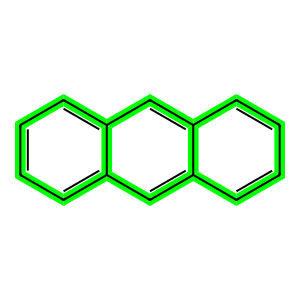

In [8]:
# Anthracene
smiles = "c1ccc2cc3ccccc3cc2c1"
mol = Chem.MolFromSmiles(smiles)
longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(mol)
print(f"Longest conjugated bond chain length is {len(longest_conjugated_bond_chain)} with bond indices: {longest_conjugated_bond_chain}")
Draw.MolToImage(
    mol,
    highlightBonds=longest_conjugated_bond_chain,
    highlightColor=(0,1,0),
    )

In [9]:
# Example usage:
# smiles = "C=C(C=C)C=CC=CC"  # Conjugated diene system
# mol = Chem.MolFromSmiles(smiles)
# longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(mol)
# print(f"Longest conjugated bond chain length is {len(longest_conjugated_bond_chain)} with bond indices: {longest_conjugated_bond_chain}")
# Draw.MolToImage(
#     mol,
#     highlightBonds=longest_conjugated_bond_chain,
#     highlightColor=(0,1,0),
#     )

In [10]:
df = pl.read_csv("../data/DB for chromophore_Sci_Data_rev02.csv")

In [11]:
df.head()

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
1,"""N#Cc1cc2ccc(O)cc2oc1=O""","""O""",355.0,410.0,2.804262,NaN,NaN,NaN,NaN,NaN,NaN,187.1537,"""DOI: 10.1021/acs.jpcb.5b09905"""
2,"""N#Cc1cc2ccc([O-])cc2oc1=O""","""O""",408.0,450.0,3.961965,NaN,NaN,NaN,NaN,NaN,43.0,186.14576,"""DOI: 10.1021/acs.jpcb.5b09905"""
3,"""CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(…","""ClC(Cl)Cl""",526.0,535.0,3.602954,NaN,NaN,NaN,NaN,NaN,NaN,1061.54348,"""https://doi.org/10.1002/smll.2…"
4,"""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","""CC#N""",514.0,553.72,3.81,NaN,NaN,NaN,NaN,NaN,67.4,350.42028,"""https://doi.org/10.1016/j.snb.…"
5,"""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","""CS(C)=O""",524.0,555.0,4.7,NaN,NaN,NaN,NaN,58.0,50.0,350.42028,"""https://doi.org/10.1016/j.snb.…"


In [12]:
def mol_props(sml):
    """
    Convert SMILES to an RDKit molecule, then calculate various properties of it
    :returns: dictionary of molecular properties
    :param sml: SMILES to convert to a molecule
    """
    mol = Chem.MolFromSmiles(sml)
    CanonicalSMILES = Chem.MolToSmiles(mol)
    longest_bond_indices = get_longest_conjugated_bond_chain(mol)
    length = len(longest_bond_indices)
    # print(f"{mol=}, {longest=}")
    return dict(
        CanonicalSMILES=CanonicalSMILES,
        longest_bond_indices=longest_bond_indices,
        longest_bond_length=length,
        )

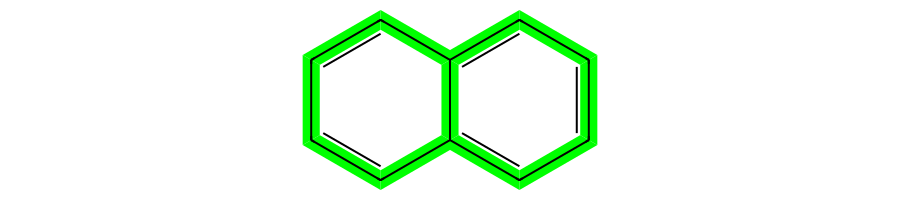

In [13]:
smiles = "c1c2ccccc2ccc1" # naphthalene
# print(example_smiles)
mol = Chem.MolFromSmiles(smiles)
conjugated_bonds = get_longest_conjugated_bond_chain(mol)
Draw.MolToImage(
    mol,
    highlightBonds=conjugated_bonds,
    highlightColor=(0,1,0),
    size=(900,200),
    useSVG=True,
    )

In [14]:
# mol_props(example_smiles)

Break

In [15]:
df = df.with_columns(
   molecular_props = pl.col('Chromophore').map_elements(mol_props)
).unnest('molecular_props')
df.head()

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,CanonicalSMILES,longest_bond_indices,longest_bond_length
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,list[i64],i64
1,"""N#Cc1cc2ccc(O)cc2oc1=O""","""O""",355.0,410.0,2.804262,NaN,NaN,NaN,NaN,NaN,NaN,187.1537,"""DOI: 10.1021/acs.jpcb.5b09905""","""N#Cc1cc2ccc(O)cc2oc1=O""","[0, 1, … 14]",15
2,"""N#Cc1cc2ccc([O-])cc2oc1=O""","""O""",408.0,450.0,3.961965,NaN,NaN,NaN,NaN,NaN,43.0,186.14576,"""DOI: 10.1021/acs.jpcb.5b09905""","""N#Cc1cc2ccc([O-])cc2oc1=O""","[0, 1, … 14]",15
3,"""CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(…","""ClC(Cl)Cl""",526.0,535.0,3.602954,NaN,NaN,NaN,NaN,NaN,NaN,1061.54348,"""https://doi.org/10.1002/smll.2…","""CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(…","[24, 25, … 84]",36
4,"""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","""CC#N""",514.0,553.72,3.81,NaN,NaN,NaN,NaN,NaN,67.4,350.42028,"""https://doi.org/10.1016/j.snb.…","""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","[0, 1, … 30]",31
5,"""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","""CS(C)=O""",524.0,555.0,4.7,NaN,NaN,NaN,NaN,58.0,50.0,350.42028,"""https://doi.org/10.1016/j.snb.…","""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","[0, 1, … 30]",31


In [16]:
df.shape

(20236, 17)

In [24]:
df = df.select(pl.all().shrink_dtype())

In [31]:
df.select(pl.all().exclude("longest_bond_indices")).write_csv("../data/DB for chromophore_Sci_Data_rev02_conjugated.csv")

In [26]:
df.plot.scatter(x="longest_bond_length", y="Absorption max (nm)")

alt.Chart(...)

In [27]:
chromophores = df["Chromophore"].to_list()
chromophores_few = [chromophores[i] for i in [0, 1, 3, 5]] + ['c1ccccc1']
chromophores_few

['N#Cc1cc2ccc(O)cc2oc1=O',
 'N#Cc1cc2ccc([O-])cc2oc1=O',
 '[O-]c1c(-c2nc3ccccc3s2)cc2ccc3cccc4ccc1c2c34',
 'CCN(CC)c1ccc2c(C)cc(=O)oc2c1',
 'c1ccccc1']

In [28]:
# for index, chromophore in enumerate(chromophores):
#     print(f"{chromophore=}")
#     mol = Chem.MolFromSmiles(chromophore)
#     start = datetime.datetime.now()
#     longest = get_longest_conjugated_bond_chain(mol)
#     stop = datetime.datetime.now()
#     # print(f"  BFS: Longest conjugated bond chain length: {len(longest)} (indices {longest}). Took {stop-start}s")
#     print(f"  Took {stop-start}s")
    
    # start = datetime.datetime.now()
    # longest = get_longest_conjugated_bond_chain_dfs(mol)
    # stop = datetime.datetime.now()
    # print(f"  DFS: Longest conjugated bond chain length: {len(longest)} (indices {longest}). Took {stop-start}s")

shape: (1, 17)
┌───────┬────────────┬───────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ Tag   ┆ Chromophor ┆ Solvent   ┆ Absorption ┆ … ┆ Reference  ┆ Canonical ┆ longest_b ┆ longest_b │
│ ---   ┆ e          ┆ ---       ┆ max (nm)   ┆   ┆ ---        ┆ SMILES    ┆ ond_indic ┆ ond_lengt │
│ i16   ┆ ---        ┆ str       ┆ ---        ┆   ┆ str        ┆ ---       ┆ es        ┆ h         │
│       ┆ str        ┆           ┆ f32        ┆   ┆            ┆ str       ┆ ---       ┆ ---       │
│       ┆            ┆           ┆            ┆   ┆            ┆           ┆ list[i64] ┆ i16       │
╞═══════╪════════════╪═══════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 19444 ┆ CC(C)[Si]( ┆ Cc1ccccc1 ┆ 589.0      ┆ … ┆ DOI: 10.10 ┆ CC(C)[Si] ┆ [4, 5, …  ┆ 115       │
│       ┆ C#Cc1c2ccc ┆           ┆            ┆   ┆ 21/acs.joc ┆ (C#Cc1c2c ┆ 134]      ┆           │
│       ┆ cc2c(C#Cc2 ┆           ┆            ┆   ┆ .8b00311   ┆ cccc2c(C# ┆

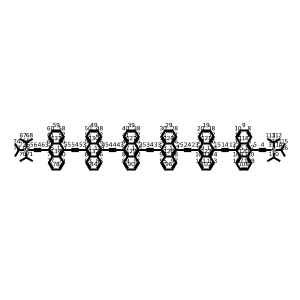

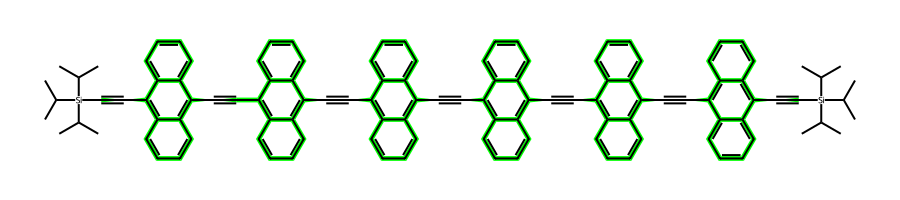

In [29]:
# Selected molecule from optical data set
# smiles='CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(=O)c2ccc3c4ccc5c6c(ccc(c7ccc(c2c37)C1=O)c64)C(=O)N(CCCCCCCCCC#CC#CCCCCCCCCCCCC)C5=O'
tag = 19444
df_filtered = df.filter(Tag=tag)
print(df_filtered)
smiles=df_filtered[0]["Chromophore"].item()
conjugated_bonds = df_filtered[0]["longest_bond_indices"].item().to_list()
print(f"{smiles=}")
print(f"{conjugated_bonds=}")
mol = Chem.MolFromSmiles(smiles)
longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(mol)
# print(f"Longest conjugated bond chain length is {len(longest_conjugated_bond_chain)} with bond indices: {longest_conjugated_bond_chain}")
label_bonds(mol)
Draw.MolToImage(
    mol,
    highlightBonds=conjugated_bonds,
    highlightColor=(0,1,0),
    size=(900,200),
    useSVG=True,
    )

Longest conjugated bond chain length is 15 with bond indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


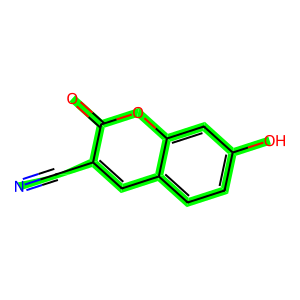

In [30]:
# First molecule from optical data set
smiles='N#Cc1cc2ccc(O)cc2oc1=O'
mol = Chem.MolFromSmiles(smiles)
longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(mol)
print(f"Longest conjugated bond chain length is {len(longest_conjugated_bond_chain)} with bond indices: {longest_conjugated_bond_chain}")

Draw.MolToImage(
    mol,
    highlightBonds=longest_conjugated_bond_chain,
    highlightColor=(0,1,0),
    )